## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import numpy as np
from collections import namedtuple

import pandas as pd
import torchvision as tv
from torchvision.transforms import v2
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

import yaml
import random
import torch.hub
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import datetime
print("Script Execution Time:", datetime.datetime.now())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/home/IITB/ai-at-ieor/23m1521/.conda/envs/flash2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Script Execution Time: 2025-05-10 22:14:35.744915
cuda


### Helpers

In [2]:
from typing import Any
from argparse import Namespace
import typing


class DotDict(Namespace):
    """A simple class that builds upon `argparse.Namespace`
    in order to make chained attributes possible."""

    def __init__(self, temp=False, key=None, parent=None) -> None:
        self._temp = temp
        self._key = key
        self._parent = parent

    def __eq__(self, other):
        if not isinstance(other, DotDict):
            return NotImplemented
        return vars(self) == vars(other)

    def __getattr__(self, __name: str) -> Any:
        if __name not in self.__dict__ and not self._temp:
            self.__dict__[__name] = DotDict(temp=True, key=__name, parent=self)
        else:
            del self._parent.__dict__[self._key]
            raise AttributeError("No attribute '%s'" % __name)
        return self.__dict__[__name]

    def __repr__(self) -> str:
        item_keys = [k for k in self.__dict__ if not k.startswith("_")]

        if len(item_keys) == 0:
            return "DotDict()"
        elif len(item_keys) == 1:
            key = item_keys[0]
            val = self.__dict__[key]
            return "DotDict(%s=%s)" % (key, repr(val))
        else:
            return "DotDict(%s)" % ", ".join(
                "%s=%s" % (key, repr(val)) for key, val in self.__dict__.items()
            )

    @classmethod
    def from_dict(cls, original: typing.Mapping[str, any]) -> "DotDict":
        """Create a DotDict from a (possibly nested) dict `original`.
        Warning: this method should not be used on very deeply nested inputs,
        since it's recursively traversing the nested dictionary values.
        """
        dd = DotDict()
        for key, value in original.items():
            if isinstance(value, typing.Mapping):
                value = cls.from_dict(value)
            setattr(dd, key, value)
        return dd

### *LPIPS*: Learned Perceptual Image Patch Similarity

In [3]:
class vgg16(nn.Module):
    def __init__(self):
        super(vgg16, self).__init__()
        vgg_pretrained_features = tv.models.vgg16(
            weights=tv.models.VGG16_Weights.IMAGENET1K_V1
        ).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
            
        self.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, X):
        h1 = self.slice1(X)
        h2 = self.slice2(h1)
        h3 = self.slice3(h2)
        h4 = self.slice4(h3)
        h5 = self.slice5(h4)
        vgg_outputs = namedtuple("VggOutputs", ['h1', 'h2', 'h3', 'h4', 'h5'])
        out = vgg_outputs(h1, h2, h3, h4, h5)
        return out


def _spatial_average(in_tens, keepdim=True):
    return in_tens.mean([2, 3], keepdim=keepdim)


def _normalize_tensor(in_feat, eps= 1e-8):
    norm_factor = torch.sqrt(eps + torch.sum(in_feat**2, dim=1, keepdim=True))
    return in_feat / norm_factor


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        # Imagnet normalization for (0-1)
        # mean = [0.485, 0.456, 0.406]
        # std = [0.229, 0.224, 0.225]

        self.register_buffer('shift', torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer('scale', torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, inp):
        return (inp - self.shift) / self.scale


class NetLinLayer(nn.Module):
    ''' A single linear layer which does a 1x1 conv '''
    def __init__(self, chn_in, chn_out=1, use_dropout=False):
        super(NetLinLayer, self).__init__()
        layers = [nn.Dropout(), ] if (use_dropout) else []
        layers += [nn.Conv2d(chn_in, chn_out, 1, stride=1, padding=0, bias=False), ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class LPIPS(nn.Module):
    def __init__(self, net='vgg', version='0.1', use_dropout=True):
        super(LPIPS, self).__init__()
        self.version = version
        self.scaling_layer = ScalingLayer()
        self.chns = [64, 128, 256, 512, 512]
        self.L = len(self.chns)
        self.net = vgg16()
        self.lin0 = NetLinLayer(self.chns[0], use_dropout=use_dropout)
        self.lin1 = NetLinLayer(self.chns[1], use_dropout=use_dropout)
        self.lin2 = NetLinLayer(self.chns[2], use_dropout=use_dropout)
        self.lin3 = NetLinLayer(self.chns[3], use_dropout=use_dropout)
        self.lin4 = NetLinLayer(self.chns[4], use_dropout=use_dropout)
        self.lins = nn.ModuleList([self.lin0, self.lin1, self.lin2, self.lin3, self.lin4])

        # --- Orignal url --------------------
        # weights_url = f"https://github.com/richzhang/PerceptualSimilarity/raw/master/lpips/weights/v{version}/{net}.pth"
        
        # --- Orignal Forked url -------------
        weights_url = f"https://github.com/akuresonite/PerceptualSimilarity-Forked/raw/master/lpips/weights/v{version}/{net}.pth"
        
        # --- Orignal torchmetric url --------
        # weights_url = "https://github.com/Lightning-AI/torchmetrics/raw/master/src/torchmetrics/functional/image/lpips_models/vgg.pth"
        
        state_dict = torch.hub.load_state_dict_from_url(weights_url, map_location='cpu')
        self.load_state_dict(state_dict, strict=False)
        
        self.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, in0, in1, normalize=False):
        # Scale the inputs to -1 to +1 range if input in [0,1]
        if normalize:
            in0 = 2 * in0 - 1
            in1 = 2 * in1 - 1

        in0_input, in1_input = self.scaling_layer(in0), self.scaling_layer(in1)
        # in0_input, in1_input = in0, in1
        
        outs0, outs1 = self.net.forward(in0_input), self.net.forward(in1_input)
        
        diffs = {}
        for kk in range(self.L):
            feats0 = _normalize_tensor(outs0[kk])
            feats1 = _normalize_tensor(outs1[kk])
            diffs[kk] = (feats0 - feats1) ** 2
            
        res = [_spatial_average(self.lins[kk](diffs[kk]), keepdim=True) for kk in range(self.L)]
        val = sum(res)
        return val.reshape(-1)

### Discriminator

In [4]:
class Discriminator(nn.Module):
    r"""
    PatchGAN Discriminator.
    Rather than taking IMG_CHANNELSxIMG_HxIMG_W all the way to
    1 scalar value , we instead predict grid of values.
    Where each grid is prediction of how likely
    the discriminator thinks that the image patch corresponding
    to the grid cell is real
    """

    def __init__(
        self,
        im_channels=3,
        conv_channels=[64, 128, 256],
        kernels=[4, 4, 4, 4],
        strides=[2, 2, 2, 1],
        paddings=[1, 1, 1, 1],
    ):
        super().__init__()
        self.im_channels = im_channels
        activation = nn.LeakyReLU(0.2)
        layers_dim = [self.im_channels] + conv_channels + [1]
        self.layers = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        layers_dim[i],
                        layers_dim[i + 1],
                        kernel_size=kernels[i],
                        stride=strides[i],
                        padding=paddings[i],
                        bias=False if i != 0 else True,
                    ),
                    (
                        nn.BatchNorm2d(layers_dim[i + 1])
                        if i != len(layers_dim) - 2 and i != 0
                        else nn.Identity()
                    ),
                    activation if i != len(layers_dim) - 2 else nn.Identity(),
                )
                for i in range(len(layers_dim) - 1)
            ]
        )

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

### *VQVAE*

In [5]:
class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        t_emb_dim,
        down_sample,
        num_heads,
        num_layers,
        attn,
        norm_channels,
        cross_attn=False,
        context_dim=None,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.attn = attn
        self.context_dim = context_dim
        self.cross_attn = cross_attn
        self.t_emb_dim = t_emb_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(
                        in_channels if i == 0 else out_channels,
                        out_channels,
                        kernel_size=3,
                        stride=1,
                        padding=1,
                    ),
                )
                for i in range(num_layers)
            ]
        )
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList(
                [
                    nn.Sequential(nn.SiLU(), nn.Linear(self.t_emb_dim, out_channels))
                    for _ in range(num_layers)
                ]
            )
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )

        if self.attn:
            self.attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels) for _ in range(num_layers)]
            )

            self.attentions = nn.ModuleList(
                [
                    nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                    for _ in range(num_layers)
                ]
            )
        if self.cross_attn:
            assert context_dim is not None, "Context Dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels) for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [
                    nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                    for _ in range(num_layers)
                ]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels) for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = (
            nn.Conv2d(out_channels, out_channels, 4, 2, 1) if self.down_sample else nn.Identity()
        )

    def forward(self, x, t_emb=None, context=None):
        out = x
        for i in range(self.num_layers):
            # Resnet block of Unet

            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            if self.attn:
                # Attention block of Unet

                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
            if self.cross_attn:
                assert (
                    context is not None
                ), "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        # Downsample

        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        t_emb_dim,
        num_heads,
        num_layers,
        norm_channels,
        cross_attn=None,
        context_dim=None,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.t_emb_dim = t_emb_dim
        self.context_dim = context_dim
        self.cross_attn = cross_attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(
                        in_channels if i == 0 else out_channels,
                        out_channels,
                        kernel_size=3,
                        stride=1,
                        padding=1,
                    ),
                )
                for i in range(num_layers + 1)
            ]
        )

        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList(
                [
                    nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_channels))
                    for _ in range(num_layers + 1)
                ]
            )
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers + 1)
            ]
        )

        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(norm_channels, out_channels) for _ in range(num_layers)]
        )

        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        if self.cross_attn:
            assert context_dim is not None, "Context Dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels) for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [
                    nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                    for _ in range(num_layers)
                ]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels) for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers + 1)
            ]
        )

    def forward(self, x, t_emb=None, context=None):
        out = x

        # First resnet block

        resnet_input = out
        out = self.resnet_conv_first[0](out)
        if self.t_emb_dim is not None:
            out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)

        for i in range(self.num_layers):
            # Attention Block

            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

            if self.cross_attn:
                assert (
                    context is not None
                ), "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
            # Resnet Block

            resnet_input = out
            out = self.resnet_conv_first[i + 1](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i + 1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i + 1](out)
            out = out + self.residual_input_conv[i + 1](resnet_input)
        return out


class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        t_emb_dim,
        up_sample,
        num_heads,
        num_layers,
        attn,
        norm_channels,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.attn = attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(
                        in_channels if i == 0 else out_channels,
                        out_channels,
                        kernel_size=3,
                        stride=1,
                        padding=1,
                    ),
                )
                for i in range(num_layers)
            ]
        )

        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList(
                [
                    nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_channels))
                    for _ in range(num_layers)
                ]
            )
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels) for _ in range(num_layers)]
            )

            self.attentions = nn.ModuleList(
                [
                    nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                    for _ in range(num_layers)
                ]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = (
            nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1)
            if self.up_sample
            else nn.Identity()
        )

    def forward(self, x, out_down=None, t_emb=None):
        # Upsample

        x = self.up_sample_conv(x)

        # Concat with Downblock output

        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)
        out = x
        for i in range(self.num_layers):
            # Resnet Block

            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            # Self Attention

            if self.attn:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        return out


class VQVAE(nn.Module):
    def __init__(self, im_channels, model_config):
        super().__init__()
        self.down_channels = model_config.down_channels
        self.mid_channels = model_config.mid_channels
        self.down_sample = model_config.down_sample
        self.num_down_layers = model_config.num_down_layers
        self.num_mid_layers = model_config.num_mid_layers
        self.num_up_layers = model_config.num_up_layers

        # To disable attention in Downblock of Encoder and Upblock of Decoder
        self.attns = model_config.attn_down

        # Latent Dimension
        self.z_channels = model_config.z_channels
        self.codebook_size = model_config.codebook_size
        self.norm_channels = model_config.norm_channels
        self.num_heads = model_config.num_heads

        # Assertion to validate the channel information
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-1]
        assert len(self.down_sample) == len(self.down_channels) - 1
        assert len(self.attns) == len(self.down_channels) - 1

        # Wherever we use downsampling in encoder correspondingly use
        # upsampling in decoder
        self.up_sample = list(reversed(self.down_sample))

        ##################### Encoder ######################
        self.encoder_conv_in = nn.Conv2d(
            im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1)
        )

        # Downblock + Midblock
        self.encoder_layers = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.encoder_layers.append(
                DownBlock(
                    self.down_channels[i],
                    self.down_channels[i + 1],
                    t_emb_dim=None,
                    down_sample=self.down_sample[i],
                    num_heads=self.num_heads,
                    num_layers=self.num_down_layers,
                    attn=self.attns[i],
                    norm_channels=self.norm_channels,
                )
            )
        self.encoder_mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.encoder_mids.append(
                MidBlock(
                    self.mid_channels[i],
                    self.mid_channels[i + 1],
                    t_emb_dim=None,
                    num_heads=self.num_heads,
                    num_layers=self.num_mid_layers,
                    norm_channels=self.norm_channels,
                )
            )
        self.encoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[-1])
        self.encoder_conv_out = nn.Conv2d(
            self.down_channels[-1], self.z_channels, kernel_size=3, padding=1
        )

        # Pre Quantization Convolution
        self.pre_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)

        # Codebook
        self.embedding = nn.Embedding(self.codebook_size, self.z_channels)
        ####################################################

        ##################### Decoder ######################

        # Post Quantization Convolution
        self.post_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        self.decoder_conv_in = nn.Conv2d(
            self.z_channels, self.mid_channels[-1], kernel_size=3, padding=(1, 1)
        )

        # Midblock + Upblock
        self.decoder_mids = nn.ModuleList([])
        for i in reversed(range(1, len(self.mid_channels))):
            self.decoder_mids.append(
                MidBlock(
                    self.mid_channels[i],
                    self.mid_channels[i - 1],
                    t_emb_dim=None,
                    num_heads=self.num_heads,
                    num_layers=self.num_mid_layers,
                    norm_channels=self.norm_channels,
                )
            )
        self.decoder_layers = nn.ModuleList([])
        for i in reversed(range(1, len(self.down_channels))):
            self.decoder_layers.append(
                UpBlock(
                    self.down_channels[i],
                    self.down_channels[i - 1],
                    t_emb_dim=None,
                    up_sample=self.down_sample[i - 1],
                    num_heads=self.num_heads,
                    num_layers=self.num_up_layers,
                    attn=self.attns[i - 1],
                    norm_channels=self.norm_channels,
                )
            )
        self.decoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[0])
        self.decoder_conv_out = nn.Conv2d(
            self.down_channels[0], im_channels, kernel_size=3, padding=1
        )

    def quantize(self, x):
        B, C, H, W = x.shape

        # B, C, H, W -> B, H, W, C
        x = x.permute(0, 2, 3, 1)

        # B, H, W, C -> B, H*W, C
        x = x.reshape(x.size(0), -1, x.size(-1))

        # Find nearest embedding/codebook vector
        # dist between (B, H*W, C) and (B, K, C) -> (B, H*W, K)
        dist = torch.cdist(x, self.embedding.weight[None, :].repeat((x.size(0), 1, 1)))
        # (B, H*W)
        min_encoding_indices = torch.argmin(dist, dim=-1)

        # Replace encoder output with nearest codebook
        # quant_out -> B*H*W, C
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))

        # x -> B*H*W, C
        x = x.reshape((-1, x.size(-1)))
        commmitment_loss = torch.mean((quant_out.detach() - x) ** 2)
        codebook_loss = torch.mean((quant_out - x.detach()) ** 2)
        quantize_losses = {"codebook_loss": codebook_loss, "commitment_loss": commmitment_loss}
        # Straight through estimation
        quant_out = x + (quant_out - x).detach()

        # quant_out -> B, C, H, W
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape(
            (-1, quant_out.size(-2), quant_out.size(-1))
        )
        return quant_out, quantize_losses, min_encoding_indices

    def encode(self, x):
        out = self.encoder_conv_in(x)
        for idx, down in enumerate(self.encoder_layers):
            out = down(out)
        for mid in self.encoder_mids:
            out = mid(out)
        out = self.encoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.encoder_conv_out(out)
        out = self.pre_quant_conv(out)
        out, quant_losses, _ = self.quantize(out)
        return out, quant_losses

    def decode(self, z):
        out = z
        out = self.post_quant_conv(out)
        out = self.decoder_conv_in(out)
        for mid in self.decoder_mids:
            out = mid(out)
        for idx, up in enumerate(self.decoder_layers):
            out = up(out)
        out = self.decoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.decoder_conv_out(out)
        return out

    def forward(self, x):
        z, quant_losses = self.encode(x)
        out = self.decode(z)
        return out, z, quant_losses

### Configuration

In [6]:
import pprint
config_path = "/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/LDM/scripts/config.yaml"
with open(config_path, 'r') as file:
    Config = yaml.safe_load(file)
    pprint.pprint(Config, width=120)

Config = DotDict.from_dict(Config)
dataset_config = Config.dataset_params
diffusion_config = Config.diffusion_params
model_config = Config.model_params
train_config = Config.train_params
paths = Config.paths

{'autoencoder_params': {'attn_down': [False, False],
                        'codebook_size': 20,
                        'down_channels': [32, 64, 128],
                        'down_sample': [True, True],
                        'mid_channels': [128, 128],
                        'norm_channels': 32,
                        'num_down_layers': 4,
                        'num_heads': 16,
                        'num_mid_layers': 4,
                        'num_up_layers': 4,
                        'z_channels': 3},
 'dataset_params': {'im_channels': 3, 'im_size': 128},
 'diffusion_params': {'beta_end': 0.0195, 'beta_start': 0.0015, 'num_timesteps': 1000},
 'ldm_params': {'attn_down': [True, True, True],
                'conv_out_channels': 128,
                'down_channels': [128, 256, 256, 256],
                'down_sample': [False, False, False],
                'mid_channels': [256, 256],
                'norm_channels': 32,
                'num_down_layers': 2,
                

### Vaani Dataset

In [7]:
# ==================================================================
#                   V A A N I - D A T A S E T
# ==================================================================
IMAGES_PATH = paths.images_dir

def walkDIR(folder_path, include=None):
    file_list = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if include is None or any(file.endswith(ext) for ext in include):
                file_list.append(os.path.join(root, file))
    print("Files found:", len(file_list))
    return file_list

files = walkDIR(IMAGES_PATH, include=['.png', '.jpeg', '.jpg'])
df = pd.DataFrame(files, columns=['image_path'])

class VaaniDataset(torch.utils.data.Dataset):
    def __init__(self, files_paths, im_size):
        self.files_paths = files_paths
        self.im_size = im_size

    def __len__(self):
        return len(self.files_paths)

    def __getitem__(self, idx):
        image = tv.io.decode_image(self.files_paths[idx], mode='RGB')
        image = v2.Resize((self.im_size,self.im_size))(image)
        image = v2.ToDtype(torch.float32, scale=True)(image)
        # image = 2*image - 1
        return image

dataset = VaaniDataset(files_paths=files, im_size=dataset_config.im_size)
image = dataset[2]
print('IMAGE SHAPE:', image.shape)

Files found: 128807
IMAGE SHAPE: torch.Size([3, 128, 128])


In [8]:
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=train_config.autoencoder_batch_size, 
    shuffle=True, 
    num_workers=os.cpu_count(),
    pin_memory=True,
    drop_last=True,
    persistent_workers=True
)

# for batch in tqdm(dataloader):
#     images = batch

images = next(iter(dataloader))
images = images.to(device)

In [9]:
images.shape

torch.Size([4, 3, 128, 128])

In [11]:
dataset_config = Config.dataset_params
autoencoder_config = Config.autoencoder_params
train_config = Config.train_params

model = VQVAE(im_channels=dataset_config.im_channels, model_config=autoencoder_config).to(device)

model_output = model(images)
model_output[0].shape, model_output[1].shape, model_output[2]

(torch.Size([4, 3, 128, 128]),
 torch.Size([4, 3, 32, 32]),
 {'codebook_loss': tensor(0.0172, device='cuda:0', grad_fn=<MeanBackward0>),
  'commitment_loss': tensor(0.0172, device='cuda:0', grad_fn=<MeanBackward0>)})

### VQVAE Training

```bash
python your_script.py 2>&1 > training.log
```

In [12]:
import time

def format_time(t1, t2):
    elapsed_time = t2 - t1
    if elapsed_time < 60:
        return f"{elapsed_time:.2f} seconds"
    elif elapsed_time < 3600:
        minutes = elapsed_time // 60
        seconds = elapsed_time % 60
        return f"{minutes:.0f} minutes {seconds:.2f} seconds"
    elif elapsed_time < 86400:
        hours = elapsed_time // 3600
        remainder = elapsed_time % 3600
        minutes = remainder // 60
        seconds = remainder % 60
        return f"{hours:.0f} hours {minutes:.0f} minutes {seconds:.2f} seconds"
    else:
        days = elapsed_time // 86400
        remainder = elapsed_time % 86400
        hours = remainder // 3600
        remainder = remainder % 3600
        minutes = remainder // 60
        seconds = remainder % 60
        return f"{days:.0f} days {hours:.0f} hours {minutes:.0f} minutes {seconds:.2f} seconds"

def save_checkpoint(
    total_steps, epoch, model, discriminator, optimizer_d, 
    optimizer_g, metrics, checkpoint_path, logs, total_training_time
):
    checkpoint = {
        "total_steps": total_steps,
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "optimizer_d_state_dict": optimizer_d.state_dict(),
        "optimizer_g_state_dict": optimizer_g.state_dict(),
        "metrics": metrics,
        "logs": logs,
        "total_training_time": total_training_time
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved after {total_steps} steps at epoch {epoch}")

def load_checkpoint(checkpoint_path, model, discriminator, optimizer_d, optimizer_g):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
        optimizer_d.load_state_dict(checkpoint["optimizer_d_state_dict"])
        optimizer_g.load_state_dict(checkpoint["optimizer_g_state_dict"])
        total_steps = checkpoint["total_steps"]
        epoch = checkpoint["epoch"]
        metrics = checkpoint["metrics"]
        logs = checkpoint.get("logs", [])
        total_training_time = checkpoint.get("total_training_time", 0)
        print(f"Checkpoint loaded. Resuming from epoch {epoch + 1}, step {total_steps}")
        return total_steps, epoch + 1, metrics, logs, total_training_time
    else:
        print("No checkpoint found. Starting from scratch.")
        return 0, 0, None, [], 0

def trainVAE(Config, dataloader):
    dataset_config = Config.dataset_params
    autoencoder_config = Config.autoencoder_params
    train_config = Config.train_params

    seed = train_config.seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device == "cuda":
        torch.cuda.manual_seed_all(seed)

    model = VQVAE(im_channels=dataset_config.im_channels, model_config=autoencoder_config).to(device)
    discriminator = Discriminator(im_channels=dataset_config.im_channels).to(device)

    optimizer_d = torch.optim.AdamW(discriminator.parameters(), lr=train_config.autoencoder_lr, betas=(0.5, 0.999))
    optimizer_g = torch.optim.AdamW(model.parameters(), lr=train_config.autoencoder_lr, betas=(0.5, 0.999))

    checkpoint_path = os.path.join(train_config.task_name, "checkpoint.pth")
    total_steps, start_epoch, metrics, logs, total_training_time = load_checkpoint(checkpoint_path, model, discriminator, optimizer_d, optimizer_g)

    if not os.path.exists(train_config.task_name):
        os.mkdir(train_config.task_name)

    num_epochs = train_config.autoencoder_epochs
    recon_criterion = torch.nn.MSELoss()
    disc_criterion = torch.nn.MSELoss()
    lpips_model = LPIPS().eval().to(device)

    acc_steps = train_config.autoencoder_acc_steps
    disc_step_start = train_config.disc_start

    start_time_total = time.time() - total_training_time

    for epoch_idx in range(start_epoch, num_epochs):
        start_time_epoch = time.time()
        epoch_log = []

        for images in dataloader:
            batch_start_time = time.time()
            total_steps += 1

            images = images.to(device)
            model_output = model(images)
            output, z, quantize_losses = model_output

            recon_loss = recon_criterion(output, images) / acc_steps

            g_loss = (
                recon_loss
                + (train_config.codebook_weight * quantize_losses["codebook_loss"] / acc_steps)
                + (train_config.commitment_beta * quantize_losses["commitment_loss"] / acc_steps)
            )

            if total_steps > disc_step_start:
                disc_fake_pred = discriminator(output)
                disc_fake_loss = disc_criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
                g_loss += train_config.disc_weight * disc_fake_loss / acc_steps

            lpips_loss = torch.mean(lpips_model(output, images)) / acc_steps
            g_loss += train_config.perceptual_weight * lpips_loss

            g_loss.backward()

            if total_steps % acc_steps == 0:
                optimizer_g.step()
                optimizer_g.zero_grad()

            if total_steps > disc_step_start:
                disc_fake_pred = discriminator(output.detach())
                disc_real_pred = discriminator(images)
                disc_loss = (disc_criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) +
                             disc_criterion(disc_real_pred, torch.ones_like(disc_real_pred))) / 2 / acc_steps
                disc_loss.backward()

                if total_steps % acc_steps == 0:
                    optimizer_d.step()
                    optimizer_d.zero_grad()

            batch_time = time.time() - batch_start_time
            epoch_log.append(format_time(0, batch_time))

        epoch_time = time.time() - start_time_epoch
        logs.append({"epoch": epoch_idx + 1, "epoch_time": format_time(0, epoch_time), "batch_times": epoch_log})

        total_training_time = time.time() - start_time_total

        save_checkpoint(total_steps, epoch_idx + 1, model, discriminator, optimizer_d, optimizer_g, metrics, checkpoint_path, logs, total_training_time)

    print("Training completed.")


In [ ]:
# trainVAE(Config)

### *VQVAE* Inference

In [18]:
import torch
import torchvision
from torchvision.utils import make_grid
import os
from PIL import Image


def load_checkpoint(checkpoint_path, model):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        total_steps = checkpoint["total_steps"]
        epoch = checkpoint["epoch"]
        total_training_time = checkpoint.get("total_training_time", 0)
        print(f"Checkpoint loaded. "
              f"Epoch: {epoch}, Step: {total_steps}, Training Time: {total_training_time}")
        return epoch
    else:
        print("No checkpoint found. Starting from scratch.")


def inference(model, dataset, save_path, epoch, device="cuda", sample_size=8):
    model.eval()
    model.to(device)

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    image_tensors = []
    for i in range(sample_size):
        image_tensors.append(dataset[i].unsqueeze(0))

    image_tensors = torch.cat(image_tensors, dim=0).to(device)
    with torch.no_grad():
        outputs, _, _ = model(image_tensors)

        save_input = image_tensors.detach().cpu()
        save_output = outputs.detach().cpu()

        grid = make_grid(torch.cat([save_input, save_output], dim=0), nrow=sample_size)

        combined_image = torchvision.transforms.ToPILImage()(grid)
        combined_image.save(os.path.join(save_path, f"reconstructed_images_EP-{epoch}_{sample_size}.png"))

    print(f"Reconstructed images saved at: {save_path}")

In [19]:
dataset_config = Config.dataset_params
autoencoder_config = Config.autoencoder_params
train_config = Config.train_params

model = VQVAE(im_channels=dataset_config.im_channels, model_config=autoencoder_config).to(device)

In [20]:
checkpoint_path = r"/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/VaaniLDM/vqvaq_ckpt.pth"
epoch = load_checkpoint(checkpoint_path, model)

/tmp/ipykernel_1245176/4087459929.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded. Epoch: 30, Step: 483004, Training Time: 186558.78681349754


In [21]:
save_image_root = r"/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/LDM/notebooks/"
save_path = os.path.join(save_image_root, "Vaani_VQVAE_Recon_Images")

In [22]:
inference(model, dataset, save_path, epoch=epoch, device=device, sample_size=16)

Reconstructed images saved at: /home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/LDM/notebooks/Vaani_VQVAE_Recon_Images


In [23]:
recon_images = [os.path.join(save_path, i) for i in sorted(os.listdir(save_path), key=lambda x: os.path.getctime(os.path.join(save_path, x)))]
recon_images

['/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/LDM/notebooks/Vaani_VQVAE_Recon_Images/reconstructed_images_EP-4.png',
 '/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/LDM/notebooks/Vaani_VQVAE_Recon_Images/reconstructed_images_EP-5.png',
 '/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/LDM/notebooks/Vaani_VQVAE_Recon_Images/reconstructed_images_EP-6.png',
 '/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/LDM/notebooks/Vaani_VQVAE_Recon_Images/reconstructed_images_EP-6_16.png',
 '/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/LDM/notebooks/Vaani_VQVAE_Recon_Images/reconstructed_images_EP-8_16.png',
 '/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/LDM/notebooks/Vaani_VQVAE_Recon_Images/reconstructed_images_EP-15_16.png',
 '/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/LDM/notebooks/Vaani_VQVAE_Recon_Images/reconstructed_images_EP-30_16.png']

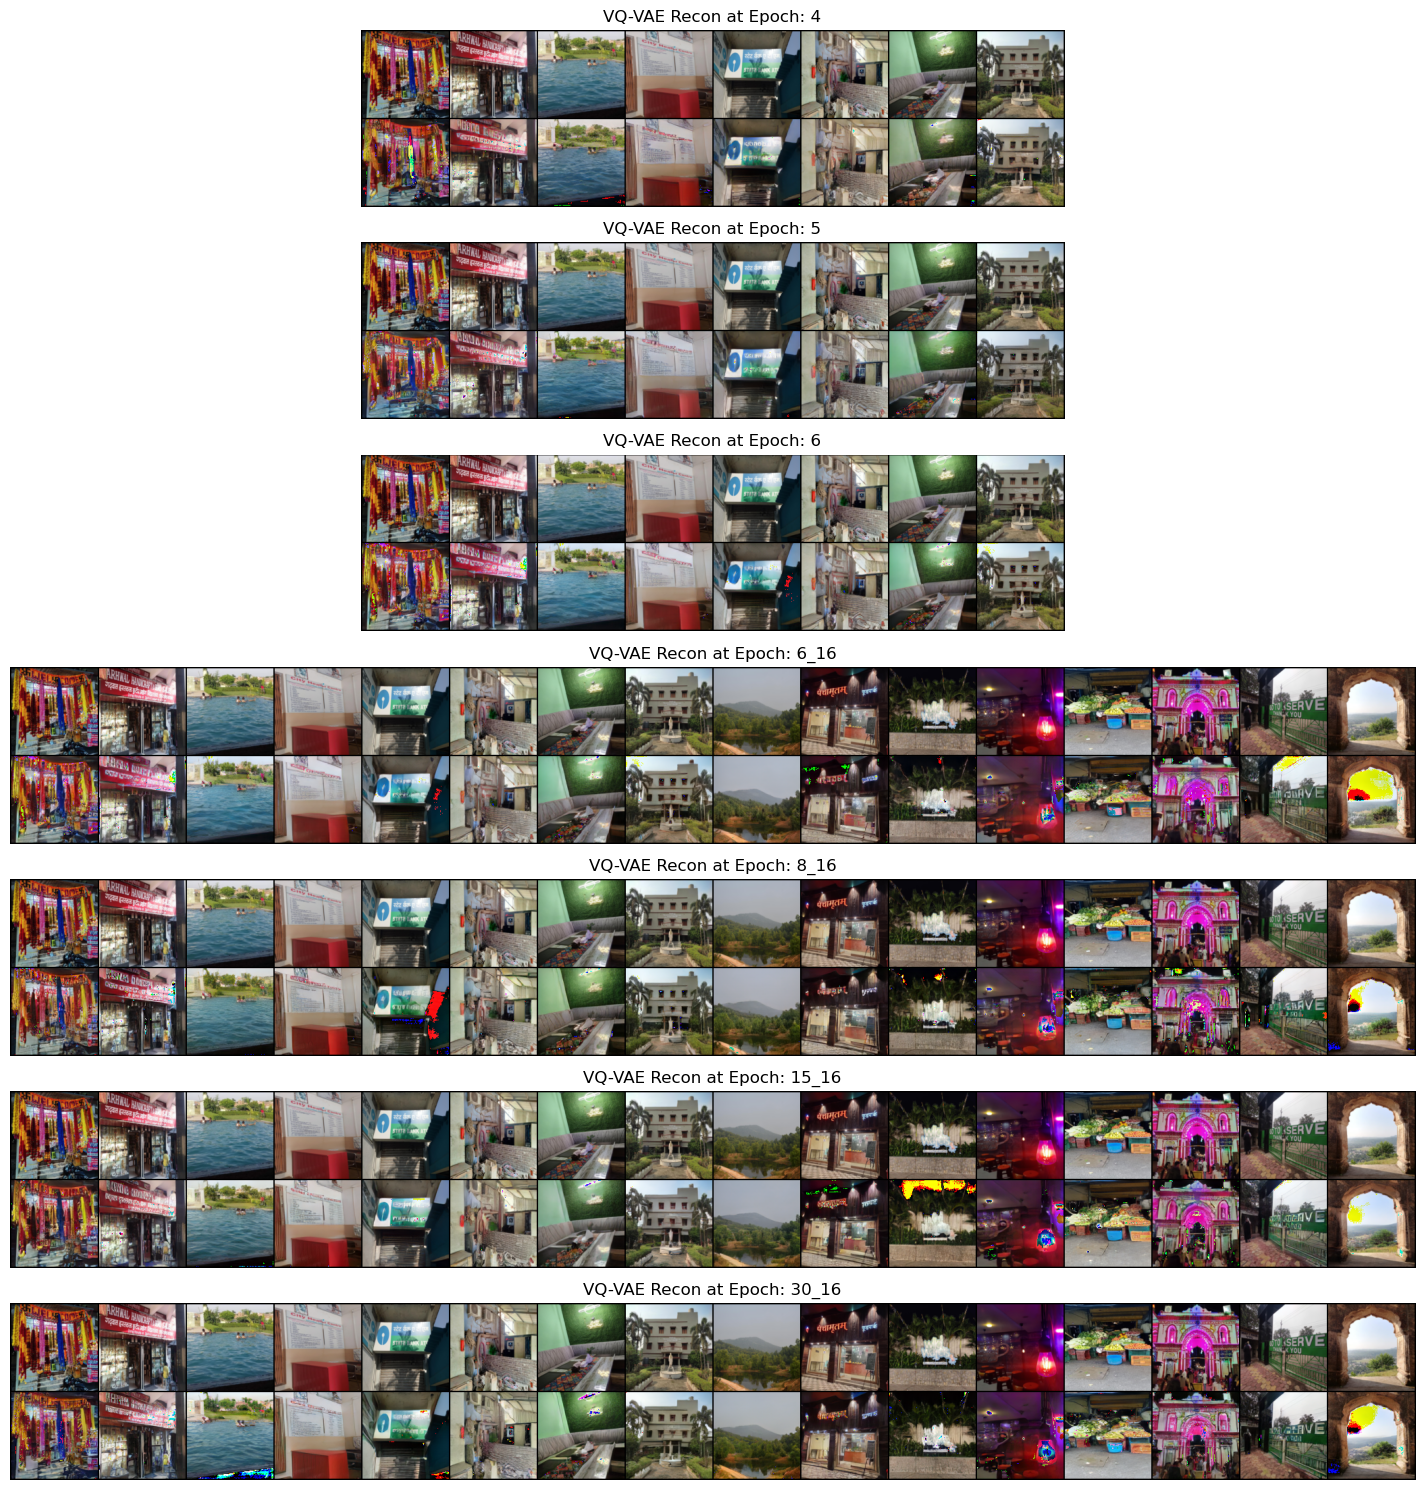

In [24]:
plt.figure(figsize=(30,15))

for i, image_path in enumerate(recon_images):
    plt.subplot(len(recon_images), 1, i+1)
    plt.imshow(plt.imread(image_path))
    plt.title(f"VQ-VAE Recon at Epoch: {image_path.split("-")[-1].split(".")[0]}")
    plt.tight_layout()
    plt.axis(False)
plt.tight_layout()
plt.savefig('Vaani-subplot.png', dpi=600, bbox_inches='tight')